<a href="https://colab.research.google.com/github/GuidoGiacomoMussini/Image_BORN/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#born

In [1]:
import scipy.sparse
import numpy
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import _check_sample_weight
from sklearn.utils.multiclass import unique_labels
from sklearn.exceptions import NotFittedError

class BornClassifier(ClassifierMixin, BaseEstimator):
    """Scikit-learn implementation of Born's Classifier

    This class is compatible with the [scikit-learn](https://scikit-learn.org) ecosystem.
    It supports both dense and sparse input and GPU-accelerated computing via [CuPy](https://cupy.dev).
    This classifier is suitable for classification with non-negative feature vectors.
    The data `X` are treated as unnormalized probability distributions.

    Parameters
    ----------
    a : float
        Amplitude. Must be strictly positive.
    b : float
        Balance. Must be non-negative.
    h : float
        Entropy. Must be non-negative.

    Attributes
    ----------
    gpu_ : bool
        Whether the model was fitted on GPU.
    corpus_ : array-like of shape (n_features_in_, n_classes)
        Fitted corpus.
    classes_ : ndarray of shape (n_classes,)
        Unique classes labels.
    n_features_in_ : int
        Number of features seen during `fit`.

    """

    def __init__(self, a=0.5, b=1., h=1.):
        self.a = a
        self.b = b
        self.h = h

    def fit(self, X, y, sample_weight=None):
        """Fit the classifier according to the training data X, y.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,) or (n_samples, n_classes)
            Target values. If 2d array, this is the probability
            distribution over the `n_classes` for each of the `n_samples`.
        sample_weight : array-like of shape (n_samples,)
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.

        Returns
        -------
        self : object
            Returns the instance itself.

        """
        attrs = [
            "gpu_",
            "corpus_",
            "classes_",
            "n_features_in_"
        ]

        for attr in attrs:
            if hasattr(self, attr):
                delattr(self, attr)

        return self.partial_fit(X, y, classes=y, sample_weight=sample_weight)

    def partial_fit(self, X, y, classes=None, sample_weight=None):
        """Incremental fit on a batch of samples.

        This method is expected to be called several times consecutively on different chunks of a dataset so
        as to implement out-of-core or online learning.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,) or (n_samples, n_classes)
            Target values. If 2d array, this is the probability
            distribution over the `n_classes` for each of the `n_samples`.
        classes : array-like of shape (n_classes,)
            List of all the classes that can possibly appear in the `y` vector.
            Must be provided at the first call to `partial_fit`, can be omitted in subsequent calls.
        sample_weight : array-like of shape (n_samples,)
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.

        Returns
        -------
        self : object
            Returns the instance itself.

        """
        X, y = self._sanitize(X, y)

        first_call = self._check_partial_fit_first_call(classes)
        if first_call:
            self.corpus_ = 0
            self.n_features_in_ = X.shape[1]

        if not self._check_encoded(y):
            y = self._one_hot_encoding(y)

        if sample_weight is not None:
            sample_weight = self._check_sample_weight(sample_weight, X)
            y = self._multiply(y, sample_weight.reshape(-1, 1))

        self.corpus_ += X.T @ self._multiply(y, self._power(self._sum(X, axis=1), -1))

        return self

    def predict(self, X):
        """Perform classification on the test data X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        y : ndarray of shape (n_samples,)
            Predicted target classes for `X`.

        """
        proba = self.predict_proba(X)
        idx = self._dense().argmax(proba, axis=1)

        return self.classes_[idx]

    def predict_proba(self, X):
        """Return probability estimates for the test data X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        y : ndarray of shape (n_samples, n_classes)
            Returns the probability of the samples for each class in the model.
            The columns correspond to the classes in sorted order, as they appear in the attribute `classes_`.

        """
        self._check_fitted()

        X = self._sanitize(X)
        u = self._power(self._power(X, self.a) @ self._weights(), 1. / self.a)
        y = self._normalize(u, axis=1)

        if self._sparse().issparse(y):
            y = y.todense()

        return self._dense().asarray(y)

    def explain(self, X=None, sample_weight=None):
        r"""Global and local explanation

        For each test vector $`x`$, the $`a`$-th power of the unnormalized probability for the $`k`$-th class is
        given by the matrix product:

        ```math
        u_k^a = \sum_j W_{jk}x_j^a
        ```
        where $`W`$ is a matrix of non-negative weights that generally depends on the model's
        hyper-parameters ($`a`$, $`b`$, $`h`$). The classification probabilities are obtained by
        normalizing $`u`$ such that it sums up to $`1`$.

        This method returns global or local feature importance weights, depending on `X`:

        - When `X` is not provided, this method returns the global weights $`W`$.

        - When `X` is a single sample,
        this method returns a matrix of entries $`(j,k)`$ where each entry is given by $`W_{jk}x_j^a`$.

        - When `X` contains multiple samples,
        then the values above are computed for each sample and this method returns their weighted sum.
        By default, each sample is given unit weight.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data, where `n_samples` is the number of samples
            and `n_features` is the number of features. If not provided,
            then global weights are returned.
        sample_weight : array-like of shape (n_samples,)
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.

        Returns
        -------
        E : array-like of shape (n_features, n_classes)
            Returns the feature importance for each class in the model.
            The columns correspond to the classes in sorted order, as they appear in the attribute `classes_`.

        """
        self._check_fitted()

        if X is None:
            return self._weights()

        X = self._sanitize(X)
        X = self._normalize(X, axis=1)
        X = self._power(X, self.a)

        if sample_weight is not None:
            sample_weight = self._check_sample_weight(sample_weight, X)
            X = self._multiply(X, sample_weight.reshape(-1, 1))

        return self._multiply(self._weights(), self._sum(X, axis=0).T)

    def _dense(self):
        return  numpy

    def _sparse(self):
        return scipy.sparse

    def _weights(self):
        P_jk = self.corpus_
        if self.b != 0:
            P_jk = self._multiply(P_jk, self._power(self._sum(self.corpus_, axis=0), -self.b))
        if self.b != 1:
            P_jk = self._multiply(P_jk, self._power(self._sum(self.corpus_, axis=1), self.b-1))

        W_jk = self._power(P_jk, self.a)
        if self.h != 0 and len(self.classes_) > 1:
            P_jk = self._normalize(P_jk, axis=1)
            H_j = 1 + self._sum(self._multiply(P_jk, self._log(P_jk)), axis=1) / self._dense().log(P_jk.shape[1])
            W_jk = self._multiply(W_jk, self._power(H_j, self.h))

        return W_jk

    def _sum(self, x, axis):
        if self._sparse().issparse(x):
            return x.sum(axis=axis)

        return self._dense().asarray(x).sum(axis=axis, keepdims=True)

    def _multiply(self, x, y):
        if self._sparse().issparse(x):
            return x.multiply(y).tocsr()

        if self._sparse().issparse(y):
            return y.multiply(x).tocsr()

        return self._dense().multiply(x, y)

    def _power(self, x, p):
        x = x.copy()

        if self._sparse().issparse(x):
            x.data = self._dense().power(x.data, p)

        else:
            nz = self._dense().nonzero(x)
            x[nz] = self._dense().power(x[nz], p)

        return x

    def _log(self, x):
        x = x.copy()

        if self._sparse().issparse(x):
            x.data = self._dense().log(x.data)

        else:
            nz = self._dense().nonzero(x)
            x[nz] = self._dense().log(x[nz])

        return x

    def _normalize(self, x, axis, p=1.):
        s = self._sum(x, axis)
        n = self._power(s, -p)

        return self._multiply(x, n)

    def _sanitize(self, X, y="no_validation"):
        only_X = isinstance(y, str) and y == "no_validation"

        gpu = self._check_gpu(X=X, y=y if not only_X else None)
        if getattr(self, "gpu_", None) is None:
            self.gpu_ = gpu

        elif self.gpu_ != gpu:
            raise ValueError(
                "X is not on the same device (CPU/GPU) as on last call "
                "to partial_fit, was: %r" % (self.gpu_, ))

        if not self.gpu_:
            kwargs = {
                "accept_sparse": "csr",
                "reset": False,
                "dtype": (numpy.float32, numpy.float64)
            }

            if only_X:
                X = super()._validate_data(X=X, **kwargs)

            else:
                X, y = super()._validate_data(X=X, y=y, multi_output=self._check_encoded(y), **kwargs)

            if not self._check_non_negative(X):
                raise ValueError("X must contain non-negative values")

        return X if only_X else (X, y)

    def _unique_labels(self, y):
        if self._check_encoded(y):
            return self._dense().arange(0, y.shape[1])

        elif self.gpu_:
            return self._dense().unique(y)

        else:
            return unique_labels(y)

    def _one_hot_encoding(self, y):
        classes = self.classes_
        n, m = len(y), len(classes)

        if self.gpu_:
            y = y.get()
            classes = classes.get()

        unseen = set(y) - set(classes)
        if unseen:
            raise ValueError(
                "`classes=%r` were not allowed on first call "
                "to partial_fit" % (unseen, ))

        idx = {c: i for i, c in enumerate(classes)}
        col = self._dense().array([idx[c] for c in y])
        row = self._dense().array(range(0, n))
        val = self._dense().ones(n)

        return self._sparse().csr_matrix((val, (row, col)), shape=(n, m))

    def _check_encoded(self, y):
        return self._sparse().issparse(y) or (getattr(y, "ndim", 0) == 2 and y.shape[1] > 1)

    def _check_non_negative(self, X):
        if self._sparse().issparse(X):
            if self._dense().any(X.data < 0):
                return False

        elif self._dense().any(X < 0):
            return False

        return True

    def _check_sample_weight(self, sample_weight, X):
        if self.gpu_:
            return sample_weight

        return _check_sample_weight(sample_weight=sample_weight, X=X)

    def _check_partial_fit_first_call(self, classes):
        if getattr(self, "classes_", None) is None and classes is None:
            raise ValueError("classes must be passed on the first call to partial_fit")

        elif classes is not None:
            classes = self._unique_labels(classes)

            if getattr(self, "classes_", None) is not None:
                if not self._dense().array_equal(self.classes_, classes):
                    raise ValueError(
                        "`classes=%r` is not the same as on last call "
                        "to partial_fit, was: %r" % (classes, self.classes_))

            else:
                self.classes_ = classes
                return True

        return False

    def _check_gpu(self, X, y=None):
        return False

    def _check_fitted(self):
        if getattr(self, "corpus_", None) is None:
            raise NotFittedError(
                f"This {self.__class__.__name__} instance is not fitted yet. "
                "Call 'fit' with appropriate arguments before using this estimator")

    def _more_tags(self):
        return {
            'requires_y': True,
            'requires_positive_X': True,
            'X_types': ['2darray', 'sparse'],
            '_xfail_checks': {
                'check_classifiers_classes':
                    'This is a pathological data set for BornClassifier. '
                    'For some specific cases, it predicts less classes than expected',
                'check_classifiers_train':
                    'Test fails because of negative values in X'
            }
        }

#data

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as progress_bar
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
def process_image(image_tensor):
    #set to 1 all the pixels != 0
    binary_image = tf.where(image_tensor > 0, 1, 0)
    return np.array(binary_image).flatten() #flatten the image

In [4]:
#MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
x_train = np.array([process_image(image) for image in progress_bar(x_train)])
x_test = np.array([process_image(image) for image in progress_bar(x_test)])

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

# results

In [6]:
#BORN
classifier = BornClassifier()
classifier.fit(x_train, y_train)
y_obs = classifier.predict(x_test)

In [23]:
print(classification_report(y_test, y_obs))

              precision    recall  f1-score   support

           0       0.73      0.91      0.81       980
           1       0.77      0.96      0.85      1135
           2       0.77      0.80      0.79      1032
           3       0.80      0.72      0.76      1010
           4       0.75      0.73      0.74       982
           5       0.77      0.57      0.66       892
           6       0.74      0.89      0.81       958
           7       0.78      0.86      0.82      1028
           8       0.78      0.41      0.54       974
           9       0.70      0.68      0.69      1009

    accuracy                           0.76     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.76      0.75     10000



<Axes: >

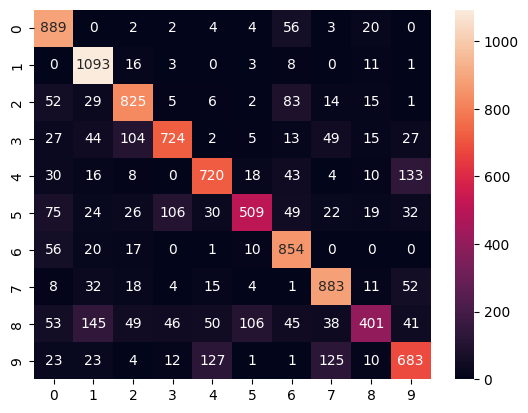

In [8]:
sns.heatmap(confusion_matrix(y_test, y_obs), annot=True, fmt='g')

In [9]:
#explain
W = classifier.explain()

<Axes: >

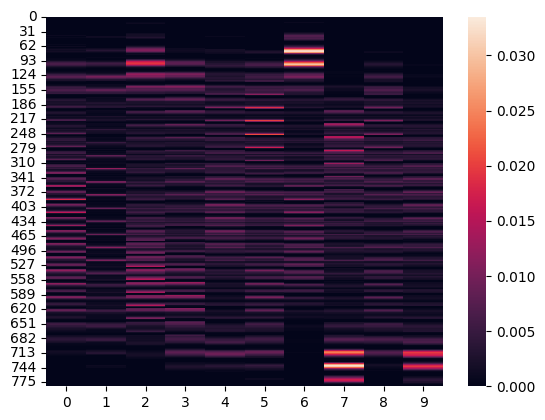

In [10]:
#explanation matrix
sns.heatmap(W)

VISUALIZE THE EXPLANATIONS

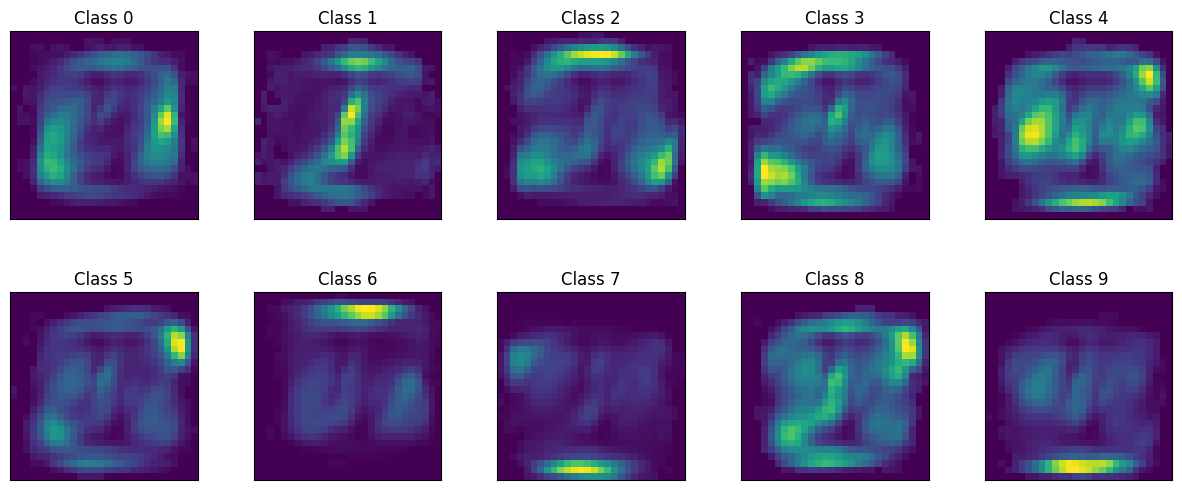

In [19]:
rows, cols = 2, 5

#subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(10):
  row = i // cols
  col = i % cols

  #extract and reshape the explanation matrix for each class
  class_importance = W[:, i].reshape(28, 28)

  #heatmap
  ax = axes[row, col]
  im = ax.imshow(class_importance, cmap='viridis', interpolation='nearest')

  ax.set_title(f"Class {i}")
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()